In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes Model for option pricing - this returns the delta
def calculate_delta(S, K, T, r, sigma, option_type="call"): #set call as the default
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    if option_type == "call":
        delta = norm.cdf(d1)
    elif option_type == "put":
        delta = -norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose either 'call' or 'put'.")
    
    return delta


In [3]:
# Simulate Geometric Brownian Motion (GBM) for random stock prices
def simulate_gbm(S0, T, r, sigma, steps, num_simulations):
    dt = T / steps
    stock_prices = np.zeros((num_simulations, steps))
    stock_prices[:, 0] = S0
    
    for t in range(1, steps):
        z = np.random.standard_normal(num_simulations)
        stock_prices[:, t] = stock_prices[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    
    return stock_prices


In [9]:
# Parameters- these drive all visuals


S0 = 110            # Initial stock price
K = 105              # Strike price
T = 30 / 365         # 30 days in years
r = 0.05             # Risk-free interest rate
sigma = 0.2          # Volatility
steps = 30           # 30 days to expiration
num_simulations = 100  # Number of Monte Carlo simulations

# Generate multiple paths for stock prices using GBM
stock_paths = simulate_gbm(S0, T, r, sigma, steps, num_simulations)

# Create a time grid for plotting
time_grid = np.linspace(0, T, steps)

# Calculate delta values for each path
call_deltas = np.array([[calculate_delta(stock_paths[i, t], K, T - t * (T / steps), r, sigma) 
                          for t in range(steps)] for i in range(num_simulations)])

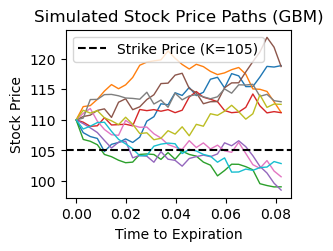

In [10]:
#plotting random stock prices generated via GBM

plt.subplot(2, 2, 1)
plt.plot(time_grid, stock_paths[:10].T, lw=1)  # Display a sample of 10 stock paths
plt.axhline(y=K, color='black', linestyle='--', label="Strike Price (K=105)")
plt.title("Simulated Stock Price Paths (GBM)")
plt.xlabel("Time to Expiration")
plt.ylabel("Stock Price")
plt.legend()

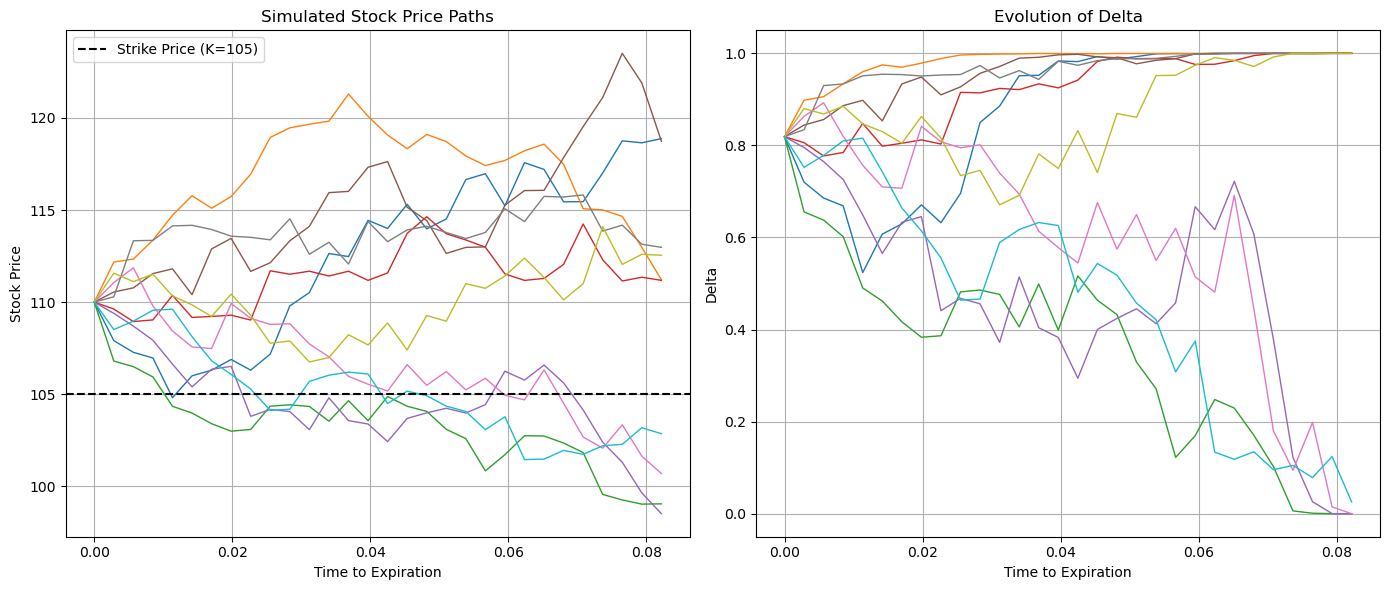

In [11]:
# Plotting simulated stock prices and delta over time
plt.figure(figsize=(14, 6))

# Plot sample of stock price paths
plt.subplot(1, 2, 1)
plt.plot(time_grid, stock_paths[:10].T, lw=1)  # Display a sample of 10 stock paths
plt.axhline(y=K, color='black', linestyle='--', label="Strike Price (K=105)")
plt.title("Simulated Stock Price Paths")
plt.xlabel("Time to Expiration")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

# Plot sample of delta paths
plt.subplot(1, 2, 2)
plt.plot(time_grid, call_deltas[:10].T, lw=1)  # Display a sample of 10 delta paths
plt.title("Evolution of Delta")
plt.xlabel("Time to Expiration")
plt.ylabel("Delta")
plt.grid()

plt.tight_layout()
plt.show()

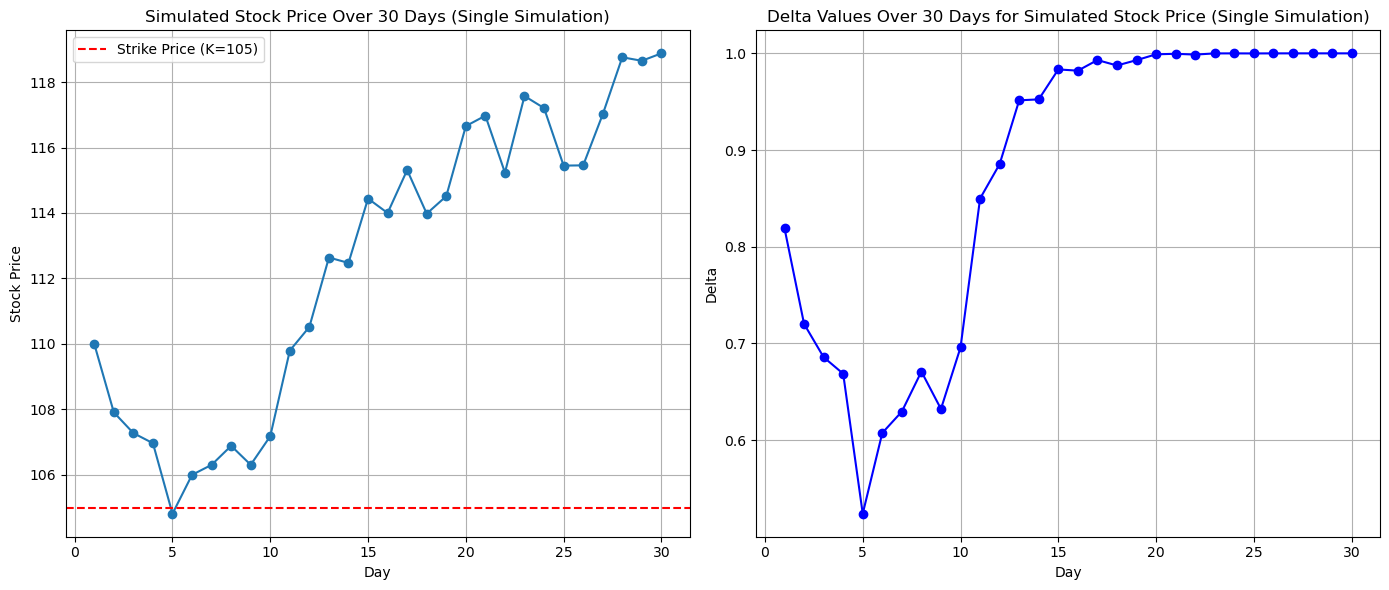

In [12]:

#creating pandas dataframe to hold stock info

delta_table = pd.DataFrame({
    "Day": np.tile(range(1, steps + 1), num_simulations),
    "Stock Price": stock_paths.flatten(),
    "Delta": call_deltas.flatten(),
    "Simulation": np.repeat(range(1, num_simulations + 1), steps)
})

# Filter to show only the first simulation 
single_simulation = delta_table[delta_table["Simulation"] == 1]

# For sizing
plt.figure(figsize=(14, 6))

# Plot the stock price
plt.subplot(1, 2, 1)
plt.plot(single_simulation["Day"], single_simulation["Stock Price"], marker='o', linestyle='-')
plt.axhline(y=K, color='red', linestyle='--', label="Strike Price (K=105)")
plt.title("Simulated Stock Price Over 30 Days (Single Simulation)")
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

# Plot the corresponding delta value
plt.subplot(1, 2, 2)
plt.plot(single_simulation["Day"], single_simulation["Delta"], marker='o', color='blue', linestyle='-')
plt.title("Delta Values Over 30 Days for Simulated Stock Price (Single Simulation)")
plt.xlabel("Day")
plt.ylabel("Delta")
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
def analyze_greek(stock_prices, K, r, sigma, greek_calculator):
    """
    Analyze a Greek over 30 calendar days including weekends
    Weekend prices use Friday's price but continue Greek calculations
    """
    results = []
    stock_idx = 0
    
    for calendar_day in range(1, 31):
        # Check if it's a weekend (after every 5 trading days)
        is_weekend = (calendar_day - 1) % 7 in [5, 6]  # 5 and 6 represent Sat and Sun
        
        # Get the appropriate stock price
        if is_weekend:
            # Use the last trading day's price for weekends
            S = results[-1]['Stock Price']
        else:
            # Use the next available stock price for trading days
            if stock_idx < len(stock_prices):
                S = stock_prices[stock_idx]
                stock_idx += 1
            else:
                # If we run out of prices, use the last known price
                S = results[-1]['Stock Price']
        
        # Calculate time to expiration
        days_to_expiration = 30 - (calendar_day - 1)
        T = max(days_to_expiration / 365, 0)
        
        # Calculate the Greek value
        greek_value = greek_calculator(S, K, T, r, sigma)
        
        # Create record
        record = {
            'Calendar Day': calendar_day,
            'Trading Day': None if is_weekend else (stock_idx),
            'Day Type': 'Weekend' if is_weekend else 'Trading Day',
            'Stock Price': S,
            'Days to Expiration': days_to_expiration,
            'Strike Price': K,
            'Volatility': sigma,
            'Delta Value': greek_value
        }
        results.append(record)
    
    return pd.DataFrame(results)

def display_greek_analysis(df):
    """Display the Greek analysis results in a columnar format"""
    pd.set_option('display.float_format', lambda x: '%.6f' % x)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)
    
    columns = ['Calendar Day', 'Day Type', 'Stock Price', 'Days to Expiration', 
               'Strike Price', 'Volatility', 'Delta Value']
    
    display_df = df[columns].copy()
    
    print("Delta Analysis Results:")
    print("=" * 120)
    print(display_df.to_string(index=False))

if __name__ == "__main__":
    # Your original 20 trading day prices
    stock_prices = [97, 81, 90, 83, 95,  # Week 1
                   98, 88, 94, 86, 89,   # Week 2
                   99, 92, 84, 87, 93,   # Week 3
                   80, 96, 85, 91, 82]   # Week 4
    
    # Parameters
    K = 92  # Strike price
    r = 0.03  # Risk-free rate
    sigma = 0.15  # Volatility
    
    # Run analysis for Delta
    results_df = analyze_greek(
        stock_prices=stock_prices,
        K=K,
        r=r,
        sigma=sigma,
        greek_calculator=calculate_delta
    )
    
    # Display results
    display_greek_analysis(results_df)

    

Delta Analysis Results:
 Calendar Day    Day Type  Stock Price  Days to Expiration  Strike Price  Volatility  Delta Value
            1 Trading Day           97                  30            92    0.150000     0.904816
            2 Trading Day           81                  29            92    0.150000     0.001672
            3 Trading Day           90                  28            92    0.150000     0.325323
            4 Trading Day           83                  27            92    0.150000     0.007170
            5 Trading Day           95                  26            92    0.150000     0.809191
            6     Weekend           95                  25            92    0.150000     0.813097
            7     Weekend           95                  24            92    0.150000     0.817206
            8 Trading Day           98                  23            92    0.150000     0.959675
            9 Trading Day           88                  22            92    0.150000     0.127

In [22]:
#export results to excel
# Export results_df to an Excel file
results_df.to_excel("delta_analysis_results.xlsx", index=False)

